In [1]:
import pandas as pd
import glob
import os
import numpy as np
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

In [2]:
# Load other Neisseria opa info
opa_neisseria = pd.read_csv('../../results/commensals/opa_commensals_metadata.csv', index_col = 0)

# Load GC opa info
filenames = glob.glob('../../results/opa_locations/*.csv')
opa_gc = pd.DataFrame()
for filename in filenames:
    strain = os.path.basename(filename)[:-4]
    df = pd.read_csv(filename, index_col = 0)
    df['strain']=strain
    opa_gc = pd.concat([opa_gc, df], ignore_index = True)

opa_gc['species'] = 'Neisseria gonorrhoeae'

# Combine opa info from all Neisseria
opa = pd.concat([opa_neisseria, opa_gc], ignore_index = True)

# Load metadata about strains
metadata_neisseria = pd.read_csv('../../input_data/complete_genome_assemblies/commensals/commensals_metadata.csv', index_col = 0)
metadata_neisseria = metadata_neisseria[['strain', 'species']]

# Add in GC metadata
metadata_gc = pd.DataFrame({'strain':np.unique(opa_gc['strain']), 'species':'Neisseria gonorrhoeae'})
metadata = pd.concat([metadata_neisseria, metadata_gc])

# Replace weird characters in strain names to match what they were for the fasta filenames
metadata['strain'] = metadata['strain'].str.replace('/', '_')
metadata['strain'] = metadata['strain'].str.replace(' ', '')

# Count number of opas in each strain

opa_counts = pd.DataFrame()

strains=[]
species_all=[]
num_opas=[]
for strain in metadata['strain']:
    strains.append(strain)
    species_all.append(metadata[metadata['strain']==strain]['species'].values[0])
    num_opas.append(len(opa[opa['strain']==strain]))

opa_counts = pd.DataFrame({'strain':strains, 'species':species_all, 'num_opa':num_opas})

# Count number of strains with a given number of opas in each species

species_all = []
num_opas = []
num_strains = []
for (species, num_opa), df in opa_counts.groupby(['species','num_opa']):
    species_all.append(species)
    num_opas.append(num_opa)
    num_strains.append(len(df))
species_opa_counts = pd.DataFrame({'species':species_all, 'num_opa':num_opas, 'num_strains':num_strains})


In [3]:
# Count number of intact opas for each strain

opa_counts_intact = pd.DataFrame()

strains=[]
species_all=[]
num_opas=[]
for strain in metadata['strain']:
    strains.append(strain)
    species_all.append(metadata[metadata['strain']==strain]['species'].values[0])
    num_opas.append(len(opa[opa['strain']==strain].dropna(subset=['id'])))

opa_counts_intact = pd.DataFrame({'strain':strains, 'species':species_all, 'num_opa':num_opas})

# Count number of strains with a given number of intact opas in each species

species_all = []
num_opas = []
num_strains = []
for (species, num_opa), df in opa_counts_intact.groupby(['species','num_opa']):
    species_all.append(species)
    num_opas.append(num_opa)
    num_strains.append(len(df))
species_opa_counts_intact = pd.DataFrame({'species':species_all, 'num_opa':num_opas, 'num_strains':num_strains})

In [4]:
# Get mean number of opa per species (for ordering the plot)
species_all = []
mean_opas = []
for species, df in opa_counts_intact.groupby('species'):
    species_all.append(species)
    mean_opas.append(np.mean(df['num_opa']))
mean_opa_by_species = pd.DataFrame({'species':species_all, 'mean_opas':mean_opas})
mean_opa_by_species.sort_values(['mean_opas', 'species'], ascending=[False, True], inplace = True, ignore_index = True)

In [5]:
# species_opa_counts['log_num_strains'] = np.log10(species_opa_counts['num_strains'])
# species_opa_counts_intact['log_num_strains'] = np.log10(species_opa_counts_intact['num_strains'])

In [6]:
# Add info about if it's a count of all opas or only intact opas
species_opa_counts['status'] = 'All'
species_opa_counts_intact['status'] = 'Intact'
species_opa_counts_all = pd.concat([species_opa_counts, species_opa_counts_intact], ignore_index = True)

# Sort order of the species for the plot

sorted_indices = []
for species in mean_opa_by_species['species']:
    idx = list(species_opa_counts_all[species_opa_counts_all['species']==species].index)
    sorted_indices = sorted_indices+idx

# sorted_indices_intact = []
# for species in mean_opa_by_species['species']:
#     idx = list(species_opa_counts_intact[species_opa_counts_intact['species']==species].index)
#     sorted_indices_intact = sorted_indices_intact+idx

In [7]:
species_opa_counts_all[species_opa_counts_all['species']=='Neisseria meningitidis']

,species,num_opa,num_strains,status
20,Neisseria meningitidis,3,7,All
21,Neisseria meningitidis,4,127,All
22,Neisseria meningitidis,5,2,All
60,Neisseria meningitidis,3,19,Intact
61,Neisseria meningitidis,4,115,Intact
62,Neisseria meningitidis,5,2,Intact


In [8]:
metadata['species'].value_counts()

species
Neisseria gonorrhoeae      219
Neisseria meningitidis     136
Neisseria subflava           9
Neisseria sp.                8
Neisseria lactamica          4
Neisseria elongata           4
Neisseria sicca              3
Neisseria mucosa             3
Neisseria leonii             3
Neisseria cinerea            2
Neisseria animalis           2
Neisseria weaveri            2
Neisseria animaloris         2
Neisseria perflava           2
Neisseria weixii             1
Neisseria chenwenguii        1
Neisseria wadsworthii        1
Neisseria brasiliensis       1
Neisseria zalophi            1
Neisseria flavescens         1
Neisseria polysaccharea      1
Neisseria shayeganii         1
Neisseria bacilliformis      1
Neisseria dentiae            1
Neisseria dumasiana          1
Neisseria macacae            1
Neisseria yangbaofengii      1
Neisseria musculi            1
Neisseria arctica            1
Neisseria lisongii           1
Neisseria canis              1
Neisseria zoodegmatis        1


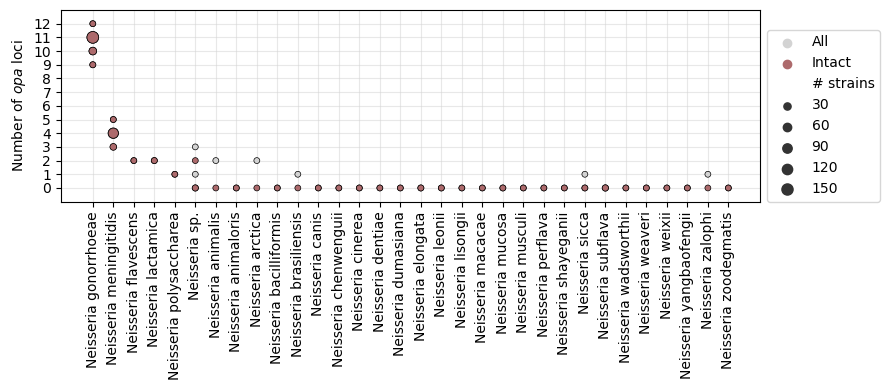

In [13]:
# Rename labels for plot
data = species_opa_counts_all.rename(columns={'status': '', 'num_strains': '# strains'})

# Plot
plt.figure(figsize = (9,4))
plt.grid(color = 'lightgrey', alpha = 0.5)
sns.scatterplot(data = data.loc[sorted_indices], y = 'num_opa', x = 'species', hue = '', size = '# strains', palette = ['lightgray', '#AD6A6C'], edgecolor = 'black', linewidth = 0.5)
plt.yticks(ticks = np.arange(0,13,1))
plt.ylim([-1, 13])
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Number of $opa$ loci')
plt.legend(loc = (1.01, 0))
plt.tight_layout()
plt.savefig('../../figures/commensals/neisseria_num_opas.png', dpi = 300)
plt.savefig('../../figures/commensals/neisseria_num_opas.pdf')
plt.show()

In [11]:
# What I don't love about the plot is that it's hard to know whether there are gray dots beneath the blue dots. 
# i.e. If there were some non-intact opas in addition to intact opas. 

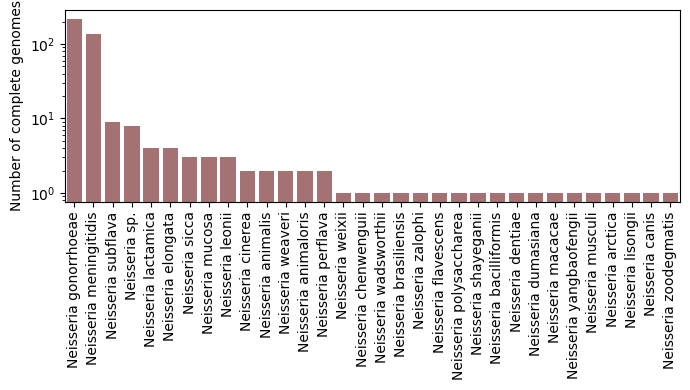

In [14]:
# Plot number of complete genomes from each species
plt.figure(figsize = (7,4))
sns.countplot(metadata, x="species", order = metadata['species'].value_counts().index, color = '#ad6a6c')
plt.yscale('log')
plt.ylabel('Number of complete genomes')
plt.xlabel('')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('../../figures/commensals/neisseria_complete_genomes.png', dpi = 300)
plt.savefig('../../figures/commensals/neisseria_complete_genomes.pdf')
plt.show()

In [78]:
# Get the sequences of the opas that were not intact
opa_neisseria_partial = opa_neisseria[opa_neisseria['id'].isnull()]
opa_neisseria_partial.sort_values('species', inplace = True, ignore_index = True)
records = []
# Add reference
records.append(list(SeqIO.parse("../../results/commensals/opa_sequences/MC58.fa", "fasta"))[0])
for i, row in opa_neisseria_partial.iterrows():
    # print(row)
    assembly = list(SeqIO.parse("../../input_data/complete_genome_assemblies/commensals/" + row['strain'] + ".fa", "fasta"))[0]
    if np.isnan(row['start'])&np.isnan(row['stop']):
        if row['strand']==1:
            start = int(row['stop_term'])-1200
            stop = int(row['stop_term'])
        elif row['strand']==-1:
            start = int(row['start_term'])
            stop = int(row['start_term'])+1200
    elif np.isnan(row['start']):
        start = int(row['stop'])-1200
        stop = int(row['stop'])
    elif np.isnan(row['stop']):
        start = int(row['start'])
        stop = int(row['start'])+1200
    seq = assembly.seq[start:stop]
    if row['strand']==-1:
        seq = seq.reverse_complement()
    records.append(SeqRecord(seq, id = row['strain'] + '_' + row['species'].replace(' ', '_') + '_' + str(start) + '_' + str(stop)))
SeqIO.write(records, '../../results/commensals/partial_opa/partial_opa.fa', 'fasta')

/tmp/ipykernel_19524/3341389252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opa_neisseria_partial.sort_values('species', inplace = True, ignore_index = True)


24

In [56]:
# Number of Nm isolates with partial opa (checked that it's one per isolate)
len(opa_neisseria_partial[opa_neisseria_partial['species']=='Neisseria meningitidis'].sort_values('strain'))

12

In [70]:
df = opa_neisseria_partial[opa_neisseria_partial['species']=='Neisseria zalophi']
df

,chromosome,strand,start_cr,stop_cr,start_term,stop_term,start,stop,id,n_terminus,in_frame,strain,species
499,NZ_CP031700.1,1,1594754.0,1594773.0,1595317.0,1595335.0,NaN,1595334.0,NaN,1595280.0,NaN,ATCCBAA-2455,Neisseria zalophi


In [80]:
df = opa_neisseria_partial[opa_neisseria_partial['strain']=='B6116_77']
df

,chromosome,strand,start_cr,stop_cr,start_term,stop_term,start,stop,id,n_terminus,in_frame,strain,species
14,NZ_CP007667.1,1,NaN,NaN,446.0,464.0,NaN,NaN,NaN,NaN,NaN,B6116_77,Neisseria meningitidis


In [ ]:
# Note that B6116_77 (Neisseria meningitidis) was just not rotated correctly and has an opa that spans the beginning/end of the genome.

In [75]:
1200-(df['stop']-df['start_cr'])

499    620.0
dtype: float64

In [77]:
opa_neisseria_partial

,chromosome,strand,start_cr,stop_cr,start_term,stop_term,start,stop,id,n_terminus,in_frame,strain,species
12,NZ_CP096117.1,-1,NaN,NaN,581237.0,581255.0,NaN,NaN,NaN,NaN,NaN,DFS-1910310016,Neisseria meningitidis
28,NZ_CP031328.1,-1,NaN,NaN,853904.0,853922.0,NaN,NaN,NaN,NaN,NaN,M18755,Neisseria meningitidis
69,NZ_CP031331.1,-1,NaN,NaN,446920.0,446938.0,NaN,NaN,NaN,NaN,NaN,M26263,Neisseria meningitidis
102,NZ_CP031326.1,1,NaN,NaN,219600.0,219618.0,NaN,NaN,NaN,NaN,NaN,M21374,Neisseria meningitidis
132,NZ_CP007667.1,1,NaN,NaN,446.0,464.0,NaN,NaN,NaN,NaN,NaN,B6116_77,Neisseria meningitidis
136,NZ_CP023814.1,-1,NaN,NaN,986936.0,986954.0,NaN,NaN,NaN,NaN,NaN,M26417,Neisseria meningitidis
152,NZ_CP091510.1,-1,NaN,NaN,1004783.0,1004801.0,NaN,NaN,NaN,NaN,NaN,KH1503,Neisseria arctica
153,NZ_CP091510.1,1,NaN,NaN,1678074.0,1678092.0,NaN,NaN,NaN,NaN,NaN,KH1503,Neisseria arctica
195,NZ_OW969598.1,-1,152755.0,152847.0,152234.0,152252.0,152235.0,NaN,NaN,152755.0,NaN,Marseille-Q6792,Neisseria sp.
236,NZ_CP018907.1,1,NaN,NaN,1288625.0,1288643.0,NaN,NaN,NaN,NaN,NaN,M21273,Neisseria meningitidis
